In [1]:
import os
os.chdir("/content/drive/MyDrive/ug-project/src")
!pwd
%load_ext autoreload
%autoreload 2

/content/drive/MyDrive/ug-project/src


In [2]:
from datasets import ToyboxDataset, TOYBOX_MEAN, TOYBOX_STD
import numpy as np
import torchvision.transforms.v2 as v2
import torch.utils.data as torchdata
from torch.utils.data import DataLoader

### Set hyperparameters

In [3]:
learning_rate = 0.005
epochs = 50
batch_size = 256
output_dir = "/content/drive/MyDrive/ug-project/output/final/toybox12_clear_final"

os.makedirs(output_dir, exist_ok=True)

### Define transforms

In [4]:
rng = np.random.default_rng(seed=5)

prob = 0.2
color_transforms = [v2.RandomApply([v2.ColorJitter(brightness=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(hue=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(saturation=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(contrast=0.2)], p=prob),
                    v2.RandomEqualize(p=prob),
                    v2.RandomPosterize(bits=4, p=prob),
                    v2.RandomAutocontrast(p=prob)
                    ]
transform = v2.Compose([v2.ToPILImage(),
                        v2.Resize((256, 256)),
                        v2.RandomResizedCrop(size=224, scale=(0.5, 1.0), interpolation=v2.InterpolationMode.BICUBIC),
                        v2.RandomOrder(color_transforms),
                        v2.RandomHorizontalFlip(),
                        v2.ToTensor(),
                        v2.Normalize(mean=TOYBOX_MEAN, std=TOYBOX_STD),
                        v2.RandomErasing(p=0.5)
                        ])
transform_test = v2.Compose([
    v2.ToPILImage(),
    v2.Resize(224),
    v2.ToTensor(),
    v2.Normalize(mean=TOYBOX_MEAN, std=TOYBOX_STD)
])

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


### Load Toybox dataset

In [5]:
train_dataset = ToyboxDataset(rng=rng, train=True, hypertune=True, transform=transform, num_images_per_class=3000)
print(f"Dev set size: {len(train_dataset)}")

val_dataset = ToyboxDataset(rng=rng, train=False, hypertune=True, transform=transform_test)
print(f"Val set size: {len(val_dataset)}")

test_dataset = ToyboxDataset(rng=rng, train=False, hypertune=False, transform=transform_test)
print(f"Test set size: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)

Dev set size: 36000
Val set size: 13299
Test set size: 13518


### Create ResNet18 model

In [6]:
import torch
import torch.nn as nn
from model import ResNet18Sup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = ResNet18Sup(num_classes=12).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
steps = len(train_loader)
warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=optimizer, start_factor=0.01, end_factor=1.0,
                                                      total_iters=2*steps)
decay_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=(epochs - 2) * steps)
combined_scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer=optimizer,
                                                            schedulers=[warmup_scheduler, decay_scheduler],
                                                            milestones=[2*steps+1])

Using device: cuda


### Evaluate model before training

In [7]:
# Initialize metrics for ploting
train_losses, train_correct = [], []
val_losses, val_correct = [], []
logs = []

model.eval()
train_loss, train_corr, total_train = 0, 0, 0

with torch.no_grad():
    for _, images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        y_pred = model(images)
        loss = criterion(y_pred, labels)

        train_loss += loss.item() * images.size(0)
        predicted = torch.max(y_pred.data, 1)[1]
        train_corr += (predicted == labels).sum().item()
        total_train += labels.size(0)

avg_train_loss = train_loss / total_train
train_accuracy = (train_corr / total_train) * 100

val_loss, val_corr, total_val = 0, 0, 0

with torch.no_grad():
    for _, images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        y_val_pred = model(images)
        loss = criterion(y_val_pred, labels)

        val_loss += loss.item() * images.size(0)
        predicted = torch.max(y_val_pred, 1)[1]
        val_corr += (predicted == labels).sum().item()
        total_val += labels.size(0)

avg_val_loss = val_loss / total_val
val_accuracy = (val_corr / total_val) * 100

# Save results for plotting
train_losses.append(avg_train_loss)
train_correct.append(train_accuracy)
val_losses.append(avg_val_loss)
val_correct.append(val_accuracy)

# Logging the results of the epoch
log_entry = (f"Epoch 0/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
print(log_entry)
logs.append(log_entry)

Epoch 0/50, Train Loss: 2.5067, Train Acc: 8.32, Val Loss: 2.4887, Val Acc: 8.64%


### Training loop

In [8]:
for epoch in range(0, epochs):

    ###################### Train model #########################
    model.train()
    for _, images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        combined_scheduler.step()

    # Evaluate on training set
    model.eval()
    train_loss, train_corr, total_train = 0, 0, 0

    with torch.no_grad():
        for _, images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            y_pred = model(images)
            loss = criterion(y_pred, labels)

            train_loss += loss.item() * images.size(0)
            predicted = torch.max(y_pred.data, 1)[1]
            train_corr += (predicted == labels).sum().item()
            total_train += labels.size(0)

    avg_train_loss = train_loss / total_train
    train_accuracy = (train_corr / total_train) * 100

    ###################### Evaluate model ######################
    val_loss, val_corr, total_val = 0, 0, 0

    with torch.no_grad():
        for _, images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            y_val_pred = model(images)
            loss = criterion(y_val_pred, labels)

            val_loss += loss.item() * images.size(0)
            predicted = torch.max(y_val_pred, 1)[1]
            val_corr += (predicted == labels).sum().item()
            total_val += labels.size(0)


    avg_val_loss = val_loss / total_val
    val_accuracy = (val_corr / total_val) * 100

    # Save results of current epoch
    train_losses.append(avg_train_loss)
    train_correct.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_correct.append(val_accuracy)

    # Add epoch results to log file
    log_entry = (f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
    print(log_entry)
    logs.append(log_entry)

    # Save checkpoint every 10 epochs
    if (epoch+1) % 10 == 0:
        checkpoint_path = os.path.join(output_dir, f'model_checkpoint_epoch{epoch+1}.pth')
        checkpoint = {
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'train_accuracy': train_accuracy,
        }
        torch.save(checkpoint, checkpoint_path)

Epoch 1/50, Train Loss: 4.6241, Train Acc: 25.27, Val Loss: 5.2603, Val Acc: 24.16%
Epoch 2/50, Train Loss: 1.8117, Train Acc: 47.83, Val Loss: 2.5091, Val Acc: 38.30%


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 3/50, Train Loss: 1.0300, Train Acc: 66.32, Val Loss: 1.7451, Val Acc: 56.17%
Epoch 4/50, Train Loss: 0.8300, Train Acc: 72.50, Val Loss: 1.8436, Val Acc: 57.68%
Epoch 5/50, Train Loss: 0.7311, Train Acc: 74.69, Val Loss: 1.7222, Val Acc: 59.87%
Epoch 6/50, Train Loss: 0.6389, Train Acc: 77.82, Val Loss: 1.7489, Val Acc: 56.00%
Epoch 7/50, Train Loss: 0.5596, Train Acc: 80.89, Val Loss: 1.4018, Val Acc: 62.00%
Epoch 8/50, Train Loss: 0.5830, Train Acc: 79.57, Val Loss: 1.9186, Val Acc: 58.72%
Epoch 9/50, Train Loss: 0.4396, Train Acc: 85.08, Val Loss: 1.8512, Val Acc: 65.04%
Epoch 10/50, Train Loss: 0.5058, Train Acc: 83.16, Val Loss: 1.6206, Val Acc: 62.14%
Epoch 11/50, Train Loss: 0.3776, Train Acc: 87.11, Val Loss: 1.7887, Val Acc: 63.40%
Epoch 12/50, Train Loss: 0.5042, Train Acc: 84.05, Val Loss: 2.0664, Val Acc: 59.91%
Epoch 13/50, Train Loss: 0.4069, Train Acc: 86.11, Val Loss: 2.3577, Val Acc: 57.67%
Epoch 14/50, Train Loss: 0.3248, Train Acc: 89.31, Val Loss: 1.9197, Val

## Test model after training

In [9]:
model.eval()
test_loss, test_correct, total_test = 0, 0, 0

with torch.no_grad():
    for _, images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        predicted = torch.max(outputs, 1)[1]
        test_correct += (predicted == labels).sum().item()
        total_test += labels.size(0)

avg_test_loss = test_loss / total_test
test_accuracy = (test_correct / total_test) * 100

# Add test results to log file
log_entry = (f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
print(log_entry)
logs.append(log_entry)

Test Loss: 1.2216, Test Accuracy: 72.77%


### Save logs to a txt file

In [10]:
import pickle

with open(f"{output_dir}/training_log.txt", 'w') as log_file:
    for log_entry in logs:
        log_file.write(log_entry + '\n')

metrics = {
    'train_losses': train_losses,
    'train_correct': train_correct,
    'val_losses': val_losses,
    'val_correct': val_correct
}

with open(f"{output_dir}/metrics.pkl", "wb") as metrics_file:
    pickle.dump(metrics, metrics_file)

### Plot loss

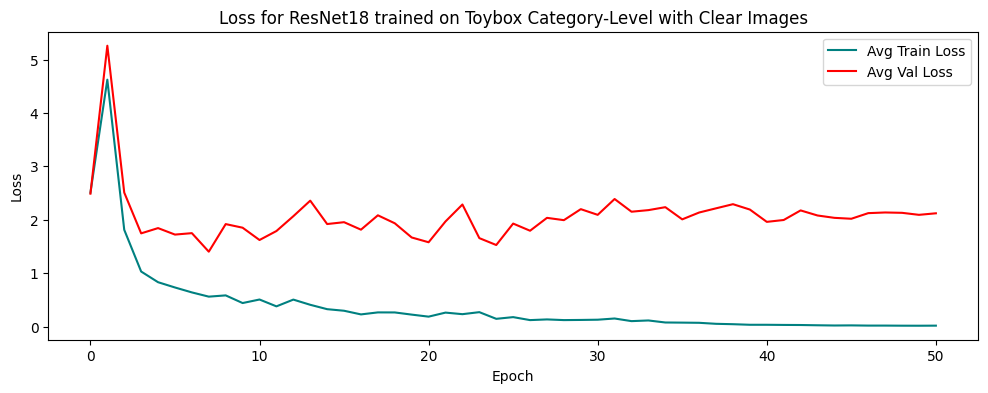

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(train_losses, color='teal', label='Avg Train Loss')
plt.plot(val_losses, color='red', label='Avg Val Loss')
plt.title(f'Loss for ResNet18 trained on Toybox Category-Level with Clear Images')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Plot accuracy

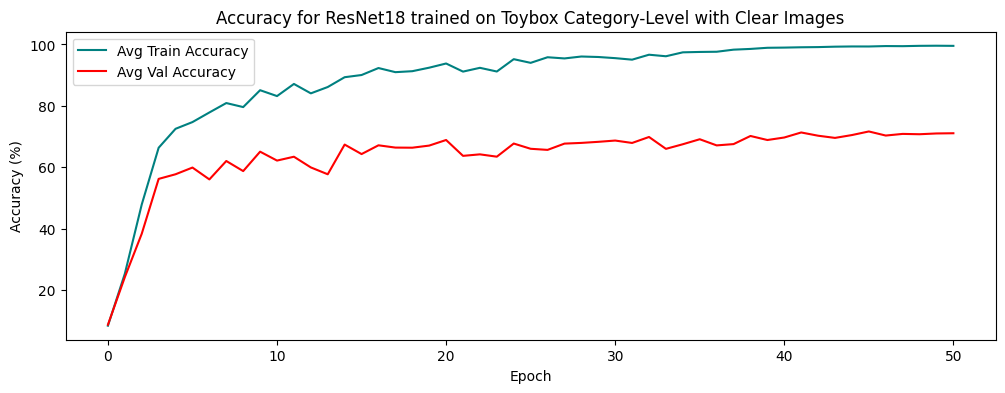

In [12]:
plt.figure(figsize=(12, 4))
plt.plot(train_correct, color='teal', label='Avg Train Accuracy')
plt.plot(val_correct, color='red', label='Avg Val Accuracy')
plt.title(f'Accuracy for ResNet18 trained on Toybox Category-Level with Clear Images')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()